The Data:
    temp  rh  wind         NO2        CO      PM2.5  holiday  time  dow  doy  \
0  12.0  39   1.6   88.316123  1.072977  53.984931        1     1    2    1   
1  16.4  50   1.8  106.075734  1.294931  82.604167        1     2    3    2   
2  15.8  61   2.3   59.930556  1.210649  62.017857        1     3    4    3   
3   9.8  71   3.0   48.361111  1.240139  35.868056        0     4    5    4   
4  11.6  68   1.8   55.395833  1.230658  43.159722        0     5    6    5   

   count  
0     26  
1     26  
2     22  
3     20  
4     30  
数据集长度： 1826
数据集shape： (1459, 2, 10) (1459,) (365, 2, 10) (365,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 2, 10)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 20)                0         
______________________________________________________

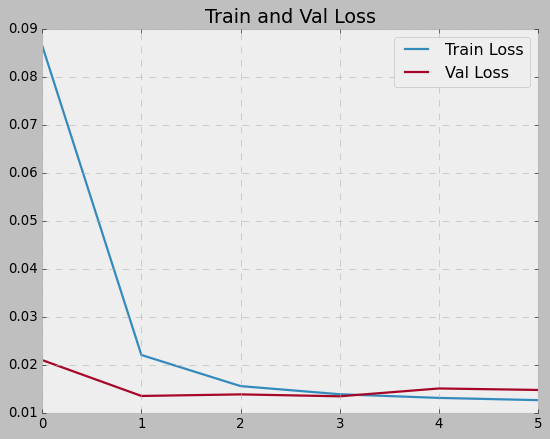

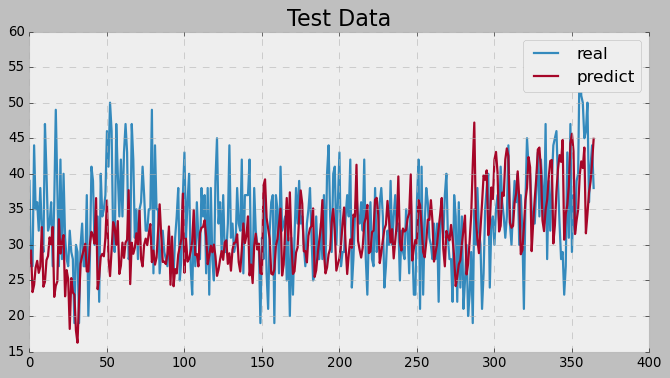

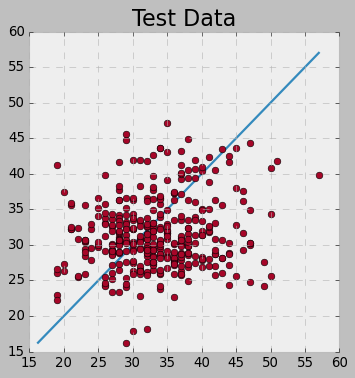

Test上的MAE/RMSE/MAPE
6.28465657691433
7.884605405519017
18.981298388154872


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
#plt.style.use('fivethirtyeight')
plt.style.use('bmh')
#plt.style.use('classic')

#设置参数
test_num=1827-1462#训练集数量
window=2#时间窗长度
rnn_units =16#rnn神经元个数
filters=32#cnn filter个数
kernel_size=1#cnn kernel个数
dense_units=32#dense层神经元个数
dropout = 0.1
epoch=50#迭代次数
batch_size=64#批处理数量
validation_split=.1#验证集比例
save_model='cnn_lstm.h5'#保存模型
choose=1#当前预测的标签
delay_factor=[0,11,4,1,0,12]#滞后参数
def deal_delay(data):
    for factor_index in range(len(delay_factor)):
        temp_col_name=data.columns[factor_index]
        temp_factor=delay_factor[factor_index]
        if temp_factor==0:
            break
        print(temp_col_name,temp_factor)
        data[temp_col_name]=np.hstack((np.zeros(temp_factor),data[temp_col_name].values[:-temp_factor]))
    return data

def read_data():
  #读取数据
  data=pd.read_excel('总的数据集.xls',header=0) 
  data=data.iloc[:,1:11+choose]
  label=data.iloc[:,-1:]#为了反归一化
  data=deal_delay(data)
  print('The Data:\n',data.head())
  #归一化
  mm_x= MinMaxScaler()
  mm_y= MinMaxScaler()
  data= mm_x.fit_transform(data)
  label= mm_y.fit_transform(label)
  #根据原始数据集构建符合神经网络的数据集
  feature_num = data.shape[1]-1
  #feature_num = data.shape[1]
  data_length=data.shape[0]
  x=[]
  y=[]
  for index in range(data_length - window):
      x.append(data[index+1: index + window+1,:-1])
      #x.append(data[index: index + window,:]) 
      y.append(data[index +window ,-1])
  x = np.array(x)
  y= np.array(y)
  x_train,y_train,x_test,y_test=x[:-test_num,:],y[:-test_num],x[-test_num:,:],y[-test_num:]
  print('数据集长度：',data_length)
  print('数据集shape：',x_train.shape,y_train.shape,x_test.shape,y_test.shape)
  return x_train,y_train,x_test,y_test,feature_num,mm_y

def cnn_lstm_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  cnn1=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs)#卷积层
  cnn1=MaxPooling1D(pool_size = window)(cnn1)#池化层
  rnn=LSTM(rnn_units, activation='relu',return_sequences=True)(cnn1)#GRU
  dense=Dropout(dropout)(rnn)#droupout层
  outputs=Lambda(lambda x:K.squeeze(x, axis=1))(dense)
  outputs = Dense(1, activation='relu')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model

def bp_model():
  #建立神经网络模型
    inputs=Input(shape=(window, feature_num))
    inputs_pp=Flatten()(inputs)
    dense=Dense(dense_units,activation='relu')(inputs_pp)#全连接层
    outputs = Dense(1, activation='relu')(dense)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

def lstm_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  rnn=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs)#GRU
  dense=Dropout(dropout)(rnn)#droupout层
  #outputs=Lambda(lambda x:K.squeeze(x, axis=1))(dense)
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model

def gru_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  rnn=GRU(rnn_units, activation='relu',return_sequences=True)(inputs)#GRU
  pooling = MaxPooling1D()(rnn)
  lam = Lambda(lambda x:K.squeeze(x, axis=1))(pooling)
  dense=Dropout(dropout)(lam)#droupout层
  #outputs=Lambda(lambda x:K.squeeze(x, axis=1))(dense)
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model

def train_model():  
  #保存最好的模型
  es = EarlyStopping(monitor='val_loss', patience=2)
  cp = ModelCheckpoint(filepath=save_model, monitor='val_loss', save_best_only=True)
  history = myModel.fit(x=x_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=2,callbacks=[es, cp],
                        validation_split=0.1)
  #迭代图像
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(len(loss))
  plt.plot(epochs_range, loss, label='Train Loss')
  plt.plot(epochs_range, val_loss, label='Val Loss')
  plt.legend(loc='upper right')
  plt.title('Train and Val Loss')
  plt.show()
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
      if abs(y_true[index])>10:
        temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
        record.append(temp_mape)
    return np.mean(record) * 100
def easy_result(y_train,y_train_predict,train_index):
    #进行反归一化
    y_train_predict=np.reshape(y_train_predict, (-1,1))  
    y_train_predict= mm_y.inverse_transform(y_train_predict)
    y_train_predict=y_train_predict[:,0]
    y_train=np.reshape(y_train, (-1,1))  
    y_train=mm_y.inverse_transform(y_train)
    y_train=y_train[:,0]
    #画图进行展示
    plt.figure(figsize=(10,5))
    plt.plot(y_train[:test_num])
    plt.plot(y_train_predict[:test_num])
    plt.legend(('real', 'predict'),fontsize='15')
    plt.title("%s Data"%train_index,fontsize='20') #添加标题
    plt.show()
    print('\n')
    plot_begin,plot_end=min(min(y_train),min(y_train_predict)),max(max(y_train),max(y_train_predict))
    plot_x=np.linspace(plot_begin,plot_end,10)
    plt.figure(figsize=(5,5))
    plt.plot(plot_x,plot_x)
    plt.plot(y_train,y_train_predict,'o')
    plt.title("%s Data"%train_index,fontsize='20') #添加标题
    plt.show()
    #输出结果
    print('%s上的MAE/RMSE/MAPE'%train_index)
    print(mean_absolute_error(y_train, y_train_predict))
    print(np.sqrt(mean_squared_error(y_train, y_train_predict) ))
    print(mape(y_train, y_train_predict) )

x_train,y_train,x_test,y_test,feature_num,mm_y=read_data()#加载数据
myModel = bp_model()#建立模型
train_model()#模型训练
myModel.load_weights(save_model) # 加载最好的训练结果  
y_test_predict=myModel.predict(x_test)#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标